In [104]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from scipy.stats import skew, kurtosis, shapiro
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from dotenv import load_dotenv


In [105]:
load_dotenv()

project_root = os.getenv('PROJECT_ROOT')
if not project_root:
    raise ValueError("PROJECT_ROOT environment variable not set.")

processed_data_dir = os.path.join(project_root, 'data', 'processed')


In [106]:
symbol = 'NVDA'
input_path = os.path.join(processed_data_dir, f'{symbol}_stock_data_processed.csv')


In [107]:
df = pd.read_csv(input_path, parse_dates=['Date'], index_col='Date')


In [108]:
df.head()


,Adj Close,Close,High,Low,Open,Volume,Ticker
Date,,,,,,,
1999-01-22 00:00:00+00:00,0.037618,0.041016,0.048828,0.038802,0.043750,2714688000,NVDA
1999-01-25 00:00:00+00:00,0.041559,0.045313,0.045833,0.041016,0.044271,510480000,NVDA
1999-01-26 00:00:00+00:00,0.038334,0.041797,0.046745,0.041146,0.045833,343200000,NVDA
1999-01-27 00:00:00+00:00,0.038215,0.041667,0.042969,0.039583,0.041927,244368000,NVDA
1999-01-28 00:00:00+00:00,0.038095,0.041536,0.041927,0.041276,0.041667,227520000,NVDA


In [109]:
df.isnull().sum()


Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
Ticker       0
dtype: int64

In [110]:
df.dtypes


Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume         int64
Ticker        object
dtype: object

In [111]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Adj Close,6486.0,7.344886e+00,1.981296e+01,3.128854e-02,2.559035e-01,4.327672e-01,4.342737e+00,1.437100e+02
Close,6486.0,7.371558e+00,1.981048e+01,3.411500e-02,2.790208e-01,4.620000e-01,4.370875e+00,1.437100e+02
High,6486.0,7.506891e+00,2.018460e+01,3.554700e-02,2.870000e-01,4.682500e-01,4.444375e+00,1.444200e+02
Low,6486.0,7.221834e+00,1.939556e+01,3.333300e-02,2.715910e-01,4.550000e-01,4.306938e+00,1.417800e+02
Open,6486.0,7.369562e+00,1.981467e+01,3.489600e-02,2.790418e-01,4.615000e-01,4.381188e+00,1.430000e+02
Volume,6486.0,6.031119e+08,4.312819e+08,1.968000e+07,3.428240e+08,5.040145e+08,7.346280e+08,9.230856e+09


In [112]:
df['Daily_Return'] = df['Close'].pct_change().dropna()


In [113]:
skewness = skew(df['Daily_Return'].dropna())
kurt = kurtosis(df['Daily_Return'].dropna(), fisher=False)
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")


Skewness: 0.6086592580930391
Kurtosis: 14.363122433254862


In [114]:
stat, p = shapiro(df['Daily_Return'].dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')



Statistics=0.902, p=0.000
Probably not Gaussian


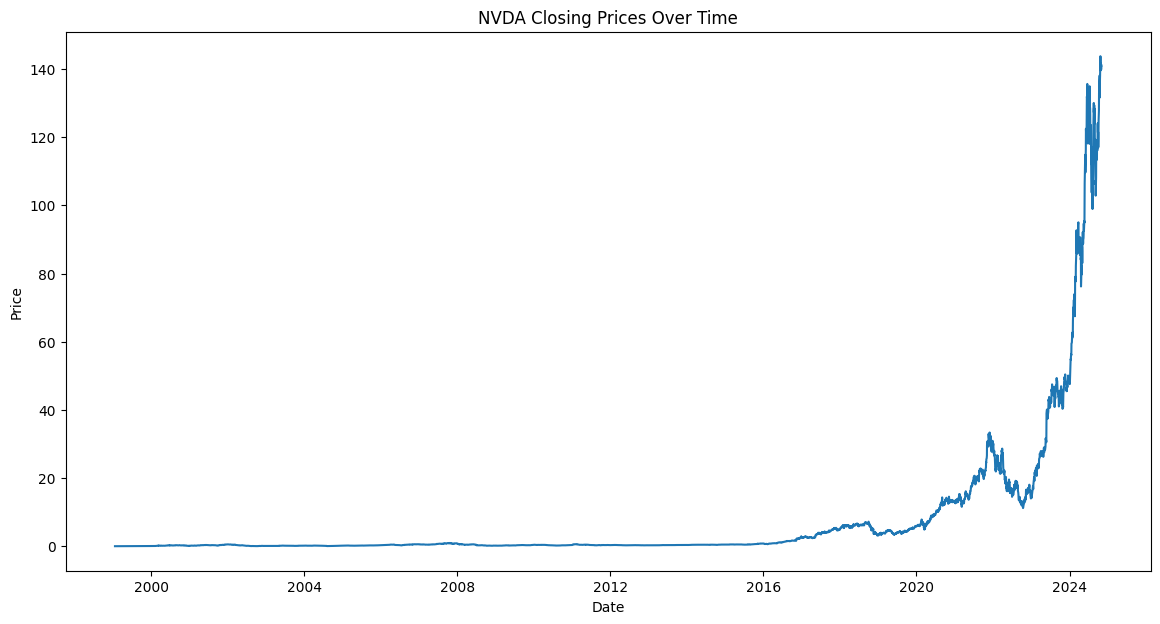

In [115]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'])
plt.title(f"{symbol} Closing Prices Over Time")
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


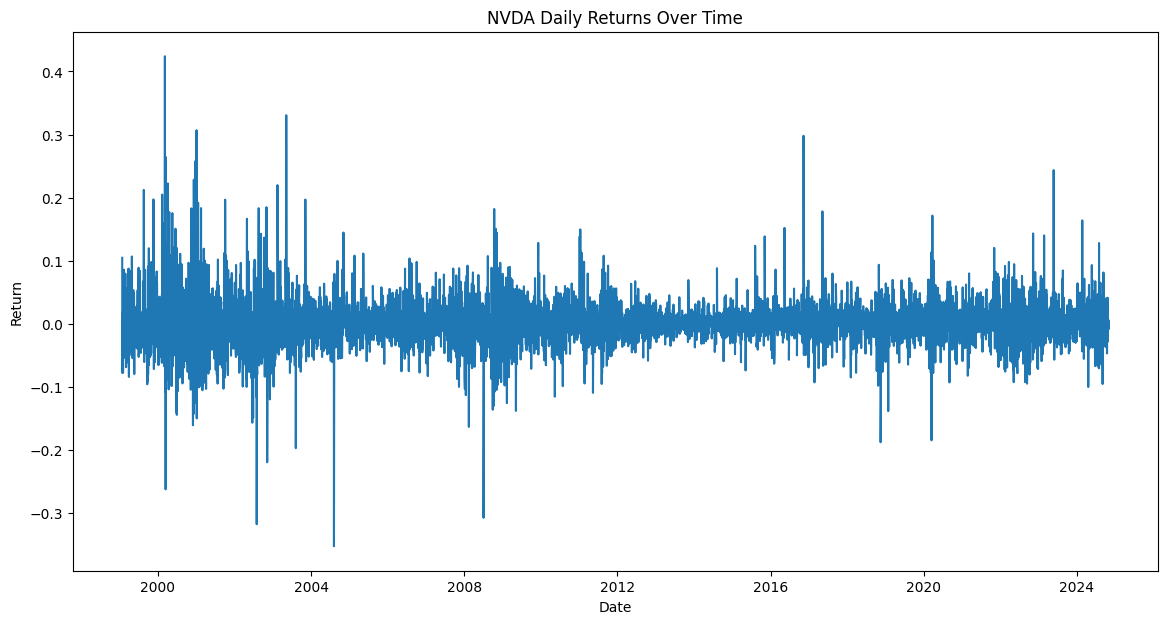

In [116]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Daily_Return'])
plt.title(f"{symbol} Daily Returns Over Time")
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()



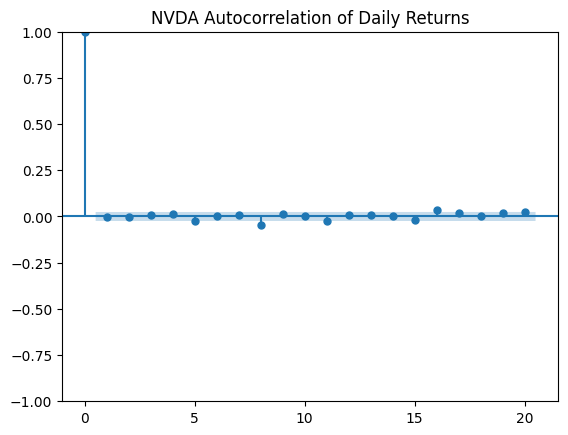

In [117]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['Daily_Return'].dropna(), lags=20)
plt.title(f"{symbol} Autocorrelation of Daily Returns")
plt.show()



In [118]:
result = adfuller(df['Daily_Return'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print('Series is stationary')
else:
    print('Series is non-stationary')


ADF Statistic: -15.880241
p-value: 0.000000
Series is stationary


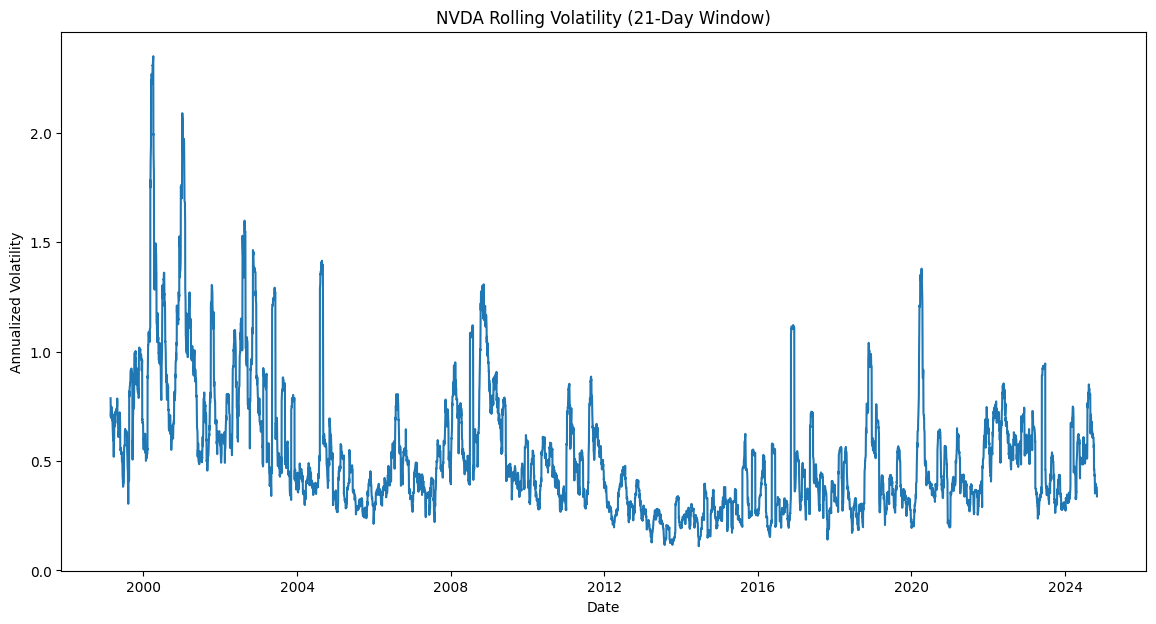

In [119]:
window_size = 21  # Approximate number of trading days in a month
df['Rolling_Volatility'] = df['Daily_Return'].rolling(window=window_size).std() * np.sqrt(252)

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Rolling_Volatility'])
plt.title(f"{symbol} Rolling Volatility (21-Day Window)")
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.show()



In [120]:
market_index = yf.download('^GSPC', start=df.index.min(), end=df.index.max())
market_index['Market_Return'] = market_index['Close'].pct_change()



[*********************100%***********************]  1 of 1 completed


In [121]:
combined_returns = pd.DataFrame({
    f'{symbol}_Return': df['Daily_Return'],
    'Market_Return': market_index['Market_Return']
}).dropna()



In [122]:
correlation = combined_returns.corr().iloc[0, 1]
print(f"Correlation between {symbol} and S&P 500 returns: {correlation}")


Correlation between NVDA and S&P 500 returns: 0.5249224294613758


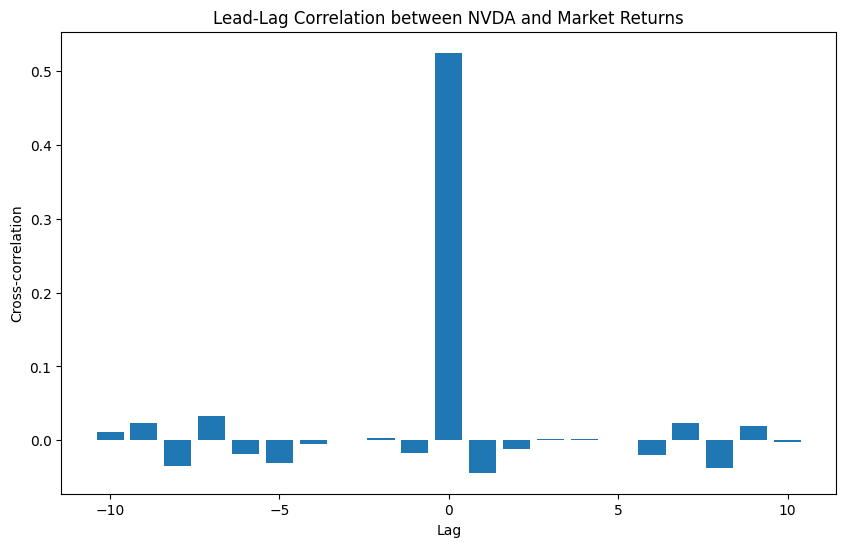

In [123]:
from scipy.signal import correlate

def cross_correlation(a, b):
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    b = (b - np.mean(b)) / np.std(b)
    return correlate(a, b, mode='full')

lags = range(-10, 11)
ccov = cross_correlation(combined_returns[f'{symbol}_Return'], combined_returns['Market_Return'])
ccov = ccov[ccov.size // 2 - 10: ccov.size // 2 + 11]

plt.figure(figsize=(10, 6))
plt.bar(lags, ccov)
plt.title(f"Lead-Lag Correlation between {symbol} and Market Returns")
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.show()



In [124]:
symbols = ['NVDA', 'AMD', 'INTC', 'TSM', 'ASML', 'QCOM', 'MU', 'AVGO', 'TXN']
price_data = pd.DataFrame()

for sym in symbols:
    temp_df = pd.read_csv(os.path.join(processed_data_dir, f'{sym}_stock_data_processed.csv'),
                          parse_dates=['Date'], index_col='Date')
    price_data[sym] = temp_df['Close']


In [125]:
returns_data = price_data.pct_change().dropna()


In [126]:
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns_data)


In [128]:
pca = PCA(n_components=0.9)  # Retain 90% variance
principal_components = pca.fit_transform(returns_scaled)
print(f"Number of principal components: {pca.n_components_}")


Number of principal components: 7


In [129]:
loadings = pd.DataFrame(pca.components_.T, index=returns_data.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
loadings


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
NVDA,0.339505,0.337939,-0.164156,-0.066714,0.041686,-0.103350,0.841850
AMD,0.287555,0.804317,0.153634,0.264313,-0.091701,-0.110185,-0.391845
INTC,0.317835,-0.313129,0.710276,0.129977,-0.319435,-0.209574,0.111256
TSM,0.336497,-0.067334,-0.405099,-0.398978,-0.471231,0.090973,-0.264307
ASML,0.351741,-0.123342,-0.206881,-0.213011,-0.224510,-0.190218,-0.031870
QCOM,0.327402,-0.209153,-0.239952,0.678866,-0.062070,0.565847,0.039674
MU,0.331060,0.060891,0.317340,-0.470246,0.465091,0.570496,-0.076493
AVGO,0.333682,-0.219029,-0.246694,0.149068,0.628267,-0.477730,-0.202922
TXN,0.368702,-0.160150,0.137523,-0.004907,0.021667,-0.122160,-0.076761


In [130]:
df['Day_of_Week'] = df.index.day_name()
avg_returns_by_day = df.groupby('Day_of_Week')['Daily_Return'].mean()
avg_returns_by_day


Day_of_Week
Friday       0.001473
Monday       0.001781
Thursday     0.002343
Tuesday      0.002263
Wednesday    0.001952
Name: Daily_Return, dtype: float64

In [131]:
from scipy.stats import ttest_ind

# Example: Compare returns on Mondays vs. Fridays
monday_returns = df[df['Day_of_Week'] == 'Monday']['Daily_Return']
friday_returns = df[df['Day_of_Week'] == 'Friday']['Daily_Return']

t_stat, p_value = ttest_ind(monday_returns.dropna(), friday_returns.dropna(), equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: 0.20192420623206658, P-value: 0.8399924406675392


In [132]:
confidence_level = 0.95
var = np.percentile(df['Daily_Return'].dropna(), (1 - confidence_level) * 100)
print(f"{int(confidence_level * 100)}% VaR: {var}")


95% VaR: -0.053436225144000586


In [133]:
cov_matrix = combined_returns.cov()
beta = cov_matrix.iloc[0, 1] / combined_returns['Market_Return'].var()
print(f"Beta of {symbol}: {beta}")


Beta of NVDA: 1.6289442628999735
